## Explore the RecSys artifacts

This notebook shows how to easily retrieve the artifacts from the Song2Vec flow, and provides some convenient functions to display and explore the original dataset and embedding space.

### Imports and global vars

First, let's make sure we are using the virtual environment with the project dependencies...

In [1]:
import sys
sys.executable

'/Users/jacopotagliabue/opt/anaconda3/envs/free/bin/python'

In [2]:
# !pip install powerlaw

Now import the packages we need

In [3]:
from metaflow import Flow
import numpy as np
from random import choice
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.manifold import TSNE
import powerlaw

Define some config / global variables

In [4]:
FLOW_NAME = 'PlaylistRecsFlow'
LOCAL_METAFLOW = True

In [5]:
if LOCAL_METAFLOW:
    print("Local Metadata for Metaflow Selected - this is a global conf!")
    from metaflow import get_metadata, metadata
    # Set the metadata provider as the src folder in the project,
    # which contains /.metaflow
    # CHANGE HERE IF YOUR FOLDER IS SOMEWHERE ELSE
    metadata('../src')
    # Fetch currently configured metadata provider - check it's local!
    print(get_metadata())

Local Metadata for Metaflow Selected - this is a global conf!
local@../src


### Get artifacts from latest successful run

In [6]:
def get_latest_successful_run(flow_name: str):
    "Gets the latest successfull run."
    for r in Flow(flow_name).runs():
        if r.successful: 
            return r

In [7]:
latest_run = get_latest_successful_run(FLOW_NAME)
latest_model = latest_run.data.final_vectors
latest_dataset = latest_run.data.final_dataset
latest_catalog = latest_run.data.final_catalog

Check all is in order by printing out some stuff

In [8]:
latest_dataset[0][0]

{'pid': 522494,
 'playlist_name': 'Wedding Playlist',
 'playlist_collaborative': 'false',
 'playlist_modified_at': 1397952000,
 'playlist_num_followers': 10,
 'playlist_num_edits': 2,
 'pos': 0,
 'track_uri': '1nnLGIasot9Qwr0KqMebl1'}

In [9]:
latest_catalog[latest_dataset[0][0]['track_uri']]

{'track_name': 'Moon Over Miami',
 'artist_uri': '1eYhYunlNJlDoQhtYBvPsi',
 'artist_name': 'Ray Charles',
 'album_uri': '3XKYSvPAmrCVaFs4gzr1Ig',
 'album_name': 'Georgia On My Mind',
 'duration_ms': 199426}

In [10]:
len(latest_dataset)

90000

In [11]:
print("# track vectors in the space: {}".format(len(latest_model)))

# track vectors in the space: 286944


In [12]:
test_track = choice(list(latest_model.index_to_key))
print("Example track: '{}', '{}'".format(test_track, latest_catalog[test_track]['track_name']))
test_vector = latest_model[test_track]
print("Test vector for '{}': {}".format(test_track, test_vector[:5]))
test_sims = latest_model.most_similar(test_track, topn=3)
print("Similar songs to '{}': {}".format(test_track, test_sims))

Example track: '7gKDhw0u8qpX8besFir9GL', 'No Lies (feat. Colbie Caillat)'
Test vector for '7gKDhw0u8qpX8besFir9GL': [-0.12731536 -0.03024677  0.10918984 -0.02279048  0.24746567]
Similar songs to '7gKDhw0u8qpX8besFir9GL': [('7KGzKbFCSRFarSPxJnOoXr', 0.9616569876670837), ('1Z7vKJ0t4yVAHl7VUej4Tk', 0.9582269787788391), ('164zrKLLqAnjvM5BbJuXiv', 0.9576497077941895)]


### Explore the dataset

Let's visualize the distribution of tracks and artist in our dataset. 

In [13]:
def plot_distribution(songs, n_bins: int=50):
    """
    Plot distributions of tracks in the final dataset.
    """
    song_counter = Counter(songs)
    print("\nTop songs: {}\n".format(song_counter.most_common(20)))
    fig, axs = plt.subplots(1, 1, tight_layout=True)
    axs.hist(song_counter.values(), bins=n_bins)
    plt.show()
    
    return song_counter

In [14]:
songs = []
for playlist in latest_dataset:
    for song in playlist:
        songs.append(song['track_uri'])
# debug
print("# of tracks", len(songs))
print("# of unique tracks", len(set(songs)))

# of tracks 5958208
# of unique tracks 643503



Top songs: [('7KXjTSCq5nL1LoYtL7XAwS', 4244), ('1xznGGDReH1oQq0xzbwXa3', 3865), ('7BKLCZ1jbUBVqRi2FVlTVw', 3744), ('3a1lNhkSLSkpJE4MSHpDu9', 3688), ('7yyRTcZmCiyzzJlNzGC9Ol', 3663), ('2EEeOnHehOozLq4aS0n6SL', 3201), ('5hTpBe8h35rJ67eAWHQsJx', 3179), ('7GX5flRQZVHRAGd6B4TmDO', 3160), ('152lZdxL1OR0ZMW6KquMif', 3147), ('4Km5HrUvYTaSUfiSGPJeQR', 3091), ('0SGkqnVQo9KPytSri1H6cF', 2979), ('5dNfHmqgr128gMY2tc5CeJ', 2973), ('0VgkVdmE4gld66l8iyGjgx', 2935), ('0v9Wz8o0BT8DU38R4ddjeH', 2848), ('6gBFPUFcJLzWGx4lenP6h2', 2837), ('62vpWI1CHwFy7tMIcSStl8', 2835), ('3kxfsdsCpFgN412fpnW85Y', 2785), ('6O6M7pJLABmfBRoGZMu76Y', 2782), ('343YBumqHu19cGoGARUTsd', 2778), ('5CtI0qwDJkDQGwXD1H1cLb', 2774)]



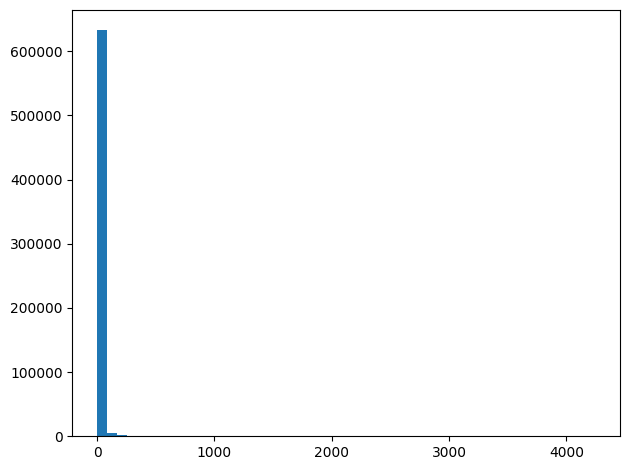

In [15]:
song_counter = plot_distribution(songs)

_BONUS: It looks like it's veeery skewed: if we want to get fancy, we can use the powerlaw library and formally compare the distribution to a powerlaw..._

Calculating best minimal value for power law fit


<AxesSubplot:>

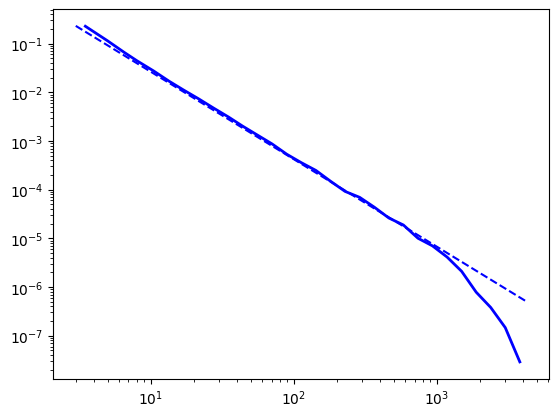

In [16]:
data = list(song_counter.values())
fit = powerlaw.Fit(data, discrete=True)
figCCDF = fit.plot_pdf(color='b', linewidth=2)
fit.power_law.plot_pdf(color='b', linestyle='--', ax=figCCDF)

### Explore the latent space

The skip-gram model we trained is an embedding space: if we did our job correctly, the space is such that tracks closer in the space are actually similar, and tracks that are far apart are pretty unrelated.

Judging the quality of "fantastic embeddings" is hard (see https://arxiv.org/abs/2007.14906), but we point here to some common qualitative checks you can run.

First, let's map some tracks to known categories: the intuition is that songs that are similar will be colored in the same way in the chart, and so we will expect them to be close in the embedding space.

In [17]:
target_categories = [
    'rock',
    'rap',
    'wedding',
    #'summer',
]

In [18]:
all_playlists = []
for playlist in latest_dataset:
    for track in playlist:
        all_playlists.append(track['playlist_name'].lower())
# debug
print(len(all_playlists))
# we tag songs based on keywords found in the playlist name
# of course, better heuristics are possible ;-)
all_playlists_names = set(all_playlists)

5958208


In [19]:
print(len(all_playlists_names))
# debug 
#print(all_playlists_names)

17861


In [20]:
# while not pretty, this select the playlists with the target keyword, and mark the tracks
# as belonging to that category
tracks_to_category = {}
for playlist in latest_dataset:
    for track in playlist:
        cnt_playlist = track['playlist_name'].lower()
        cnt_track = track['track_uri']
        # default
        tracks_to_category[cnt_track] = 'unknown'
        for c in target_categories:
            if cnt_playlist in c:
                tracks_to_category[cnt_track] = c
                
# debug
vals = list(tracks_to_category.values())
for t in target_categories:
    print(t, len([_ for _ in vals if _ == t]))

rock 3598
rap 3442
wedding 1188


In [21]:
# we downsample the vector space a bit to the K most common songs to avoid crowding the plot / analysis
TOP_N_TRACKS = 500
top_tracks = [_[0] for _ in song_counter.most_common(TOP_N_TRACKS)]
tracks = [_ for _ in latest_model.index_to_key if _ in top_tracks]

assert TOP_N_TRACKS == len(tracks)

In [22]:
for track, cat in tracks_to_category.items():
    # add a track if we have a tag, if not there already, if we have a vector for it
    if cat in target_categories and track in latest_model.index_to_key and track not in tracks:
        tracks.append(track)
    
print(len(tracks))  

4581


Note: _to visualize a n-dimensional space, we first need to bring it to 2D (https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)_ 

In [23]:
def tsne_analysis(embeddings, perplexity=50, n_iter=1000):
    """
    TSNE dimensionality reduction of track embeddings - it may take a while!
    """
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, verbose=1)
    return tsne.fit_transform(embeddings)

In [24]:
def build_tsne_from_tracks(model, tracks):
    # extract the vectors from the model and project them in 2D
    embeddings = np.array([model[t] for t in tracks])
    # debug, print out embedding shape
    print(embeddings.shape)
    tsne_results = tsne_analysis(embeddings)
    assert len(tsne_results) == len(tracks)

    return tsne_results, embeddings

In [25]:
tsne_results, embeddings = build_tsne_from_tracks(latest_model, tracks)

(4581, 48)
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 4581 samples in 0.000s...


/Users/jacopotagliabue/opt/anaconda3/envs/free/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/jacopotagliabue/opt/anaconda3/envs/free/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 4581 samples in 0.362s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4581
[t-SNE] Computed conditional probabilities for sample 2000 / 4581
[t-SNE] Computed conditional probabilities for sample 3000 / 4581
[t-SNE] Computed conditional probabilities for sample 4000 / 4581
[t-SNE] Computed conditional probabilities for sample 4581 / 4581
[t-SNE] Mean sigma: 0.240772
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.591965
[t-SNE] KL divergence after 1000 iterations: 1.348352


In [26]:
def plot_scatterplot_with_lookup(
    title: str, 
    items: list, 
    items_to_target_cat: dict,
    vectors: list):
    """
    Plot the 2-D vectors in the space, and use the mapping items_to_target_cat
    to color-code the points for convenience
    """
    
    groups = {}
    for item in items:
        item_idx = items.index(item)
        target_cat = items_to_target_cat[item]
        x = vectors[item_idx][0]
        y = vectors[item_idx][1]
        if target_cat in groups:
            groups[target_cat]['x'].append(x)
            groups[target_cat]['y'].append(y)
        else:
            groups[target_cat] = {
                'x': [x], 'y': [y]
                }
    
    fig, ax = plt.subplots(figsize=(10, 10))
    for group, data in groups.items():
        ax.scatter(data['x'], data['y'], 
                   alpha=0.1 if group == 'unknown' else 0.8, 
                   edgecolors='none', 
                   s=25, 
                   marker='o',
                   label=group)

    plt.title(title)
    plt.legend(loc=2)
    plt.show()
    
    return

Finally, we are ready to plot the latent space!

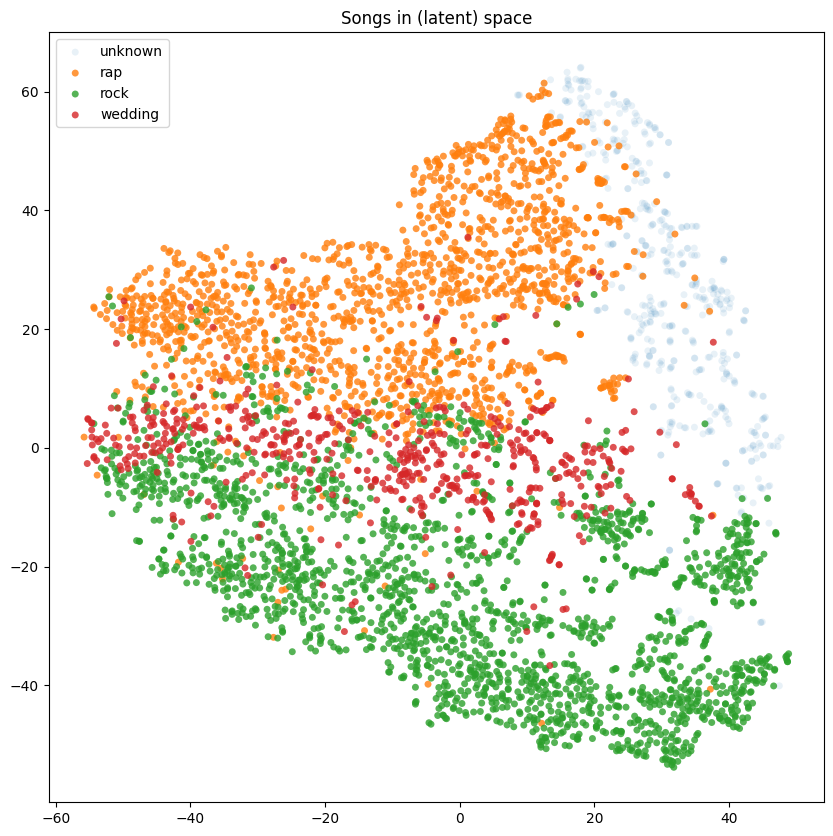

In [27]:
plot_scatterplot_with_lookup(
    'Songs in (latent) space', 
    tracks, 
    tracks_to_category, 
    tsne_results)

_Let's do the same with artists!_

In [28]:
all_artists = []
for playlist in latest_dataset:
    for track in playlist:
        all_artists.append(latest_catalog[track['track_uri']]['artist_name'].lower())
        
Counter(all_artists).most_common(20)

[('drake', 75644),
 ('kanye west', 36694),
 ('kendrick lamar', 32046),
 ('rihanna', 30601),
 ('the weeknd', 28013),
 ('eminem', 27581),
 ('ed sheeran', 24398),
 ('future', 22155),
 ('j. cole', 21138),
 ('justin bieber', 20804),
 ('beyoncé', 20798),
 ('the chainsmokers', 20360),
 ('chris brown', 19276),
 ('twenty one pilots', 18407),
 ('calvin harris', 18193),
 ('lil uzi vert', 17880),
 ('post malone', 17344),
 ('big sean', 17055),
 ('maroon 5', 16974),
 ('migos', 16387)]

In [29]:
target_artists = [
    'drake',
    'maroon 5',
    'eminem',
    'beyoncé'
]

tracks_to_artists = {}
for playlist in latest_dataset:
    for track in playlist:
        cnt_track = track['track_uri']
        cnt_artist = latest_catalog[cnt_track]['artist_name'].lower()
        tracks_to_artists[cnt_track] = 'unknown'
        for a in target_artists:
            if a == cnt_artist:
                tracks_to_artists[cnt_track] = a
                
# debug
vals = list(tracks_to_artists.values())
for a in target_artists:
    print(a, len([_ for _ in vals if _ == a]))

drake 142
maroon 5 160
eminem 201
beyoncé 221


In [41]:
top_tracks = [_[0] for _ in song_counter.most_common(TOP_N_TRACKS * 3)]
tracks = [_ for _ in latest_model.index_to_key if _ in top_tracks]

for track, artist in tracks_to_artists.items():
    # add a track if we have a tag, if not there already, if we have a vector for it
    if artist in target_artists and track in latest_model.index_to_key and track not in tracks:
        tracks.append(track)
    
print(len(tracks))  

2072


In [42]:
tsne_results, embeddings = build_tsne_from_tracks(latest_model, tracks)

(2072, 48)
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2072 samples in 0.000s...
[t-SNE] Computed neighbors for 2072 samples in 0.072s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2072
[t-SNE] Computed conditional probabilities for sample 2000 / 2072
[t-SNE] Computed conditional probabilities for sample 2072 / 2072
[t-SNE] Mean sigma: 1.629406


/Users/jacopotagliabue/opt/anaconda3/envs/free/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/jacopotagliabue/opt/anaconda3/envs/free/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.407974
[t-SNE] KL divergence after 1000 iterations: 1.045892


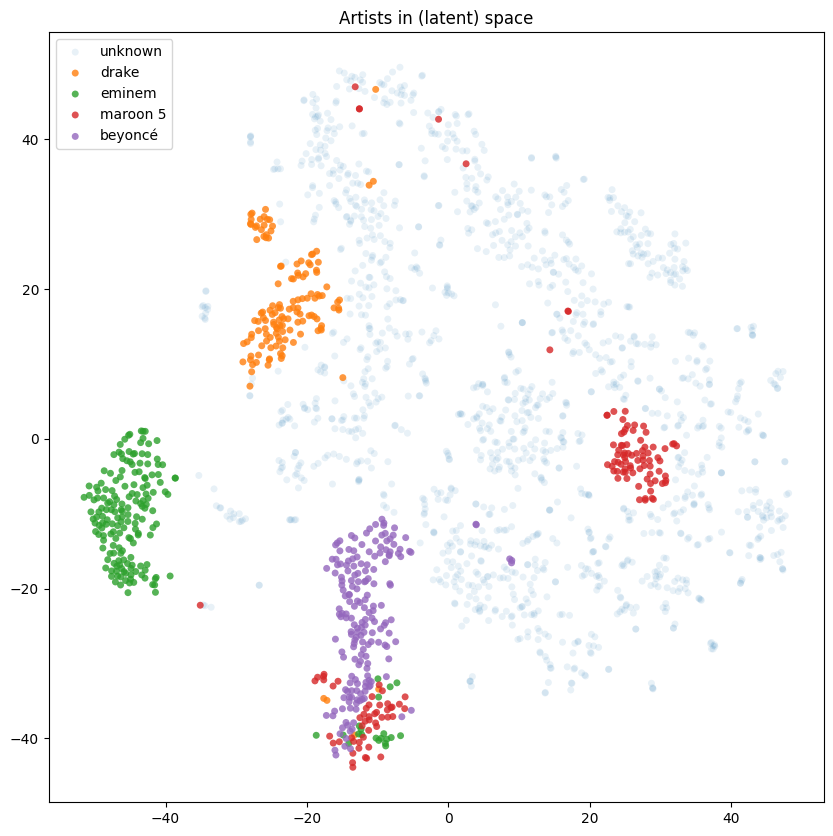

In [43]:
plot_scatterplot_with_lookup(
    'Artists in (latent) space', 
    tracks, 
    tracks_to_artists, 
    tsne_results)

### A song classifier

Aside from visual inspection, can we "measure" how good are our embeddings?

A "heuristic" we can use leverages the song catalog: if we can train a classifier that distinguishes eminem songs from beyonce song _purely based on the position in the vector space_ that is a good "quantitative" proxy for a good similarity space. In particular, we could try and use this concept to evaluate different latent spaces!

So we are building a simple classifier that takes in input an embedding for a song, and as output pick the artist that is most likely to be the author of that song (a MLP with Keras would probably works better - see for example last year class: https://github.com/jacopotagliabue/FREE_7773/blob/main/notebooks/Intro_to_Word_Embeddings.ipynb).

[ First, make sure scikit is up to date ]

In [44]:
#!pip install scikit-learn  -U

In [45]:
from sklearn.model_selection import train_test_split

X = embeddings
labels = target_artists + ['unknown']
y = [labels.index(tracks_to_artists[t]) for t in tracks]

assert len(y) == embeddings.shape[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [46]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
predicted = clf.predict(X_test)

In [47]:
from sklearn.metrics import confusion_matrix, classification_report

def calculate_confusion_matrix_and_report(y_predicted, y_golden, with_plot=True):
    # calculate confusion matrix: 
    cm = confusion_matrix(y_golden, y_predicted)
    # build a readable report;
    # https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report
    print('\nClassification Report')
    print(classification_report(y_golden, y_predicted))
    # plot the matrix
    if with_plot:
        plot_confusion_matrix(cm)
                                          
    return
                                          
def plot_confusion_matrix(c_matrix):
    plt.imshow(c_matrix, cmap=plt.cm.Blues)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title("Confusion matrix")
    plt.colorbar()
    plt.show()
    
    return


Classification Report
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        28
           1       0.87      0.93      0.90        28
           2       1.00      1.00      1.00        29
           3       0.98      0.94      0.96        47
           4       0.99      0.99      0.99       283

    accuracy                           0.98       415
   macro avg       0.97      0.96      0.97       415
weighted avg       0.98      0.98      0.98       415



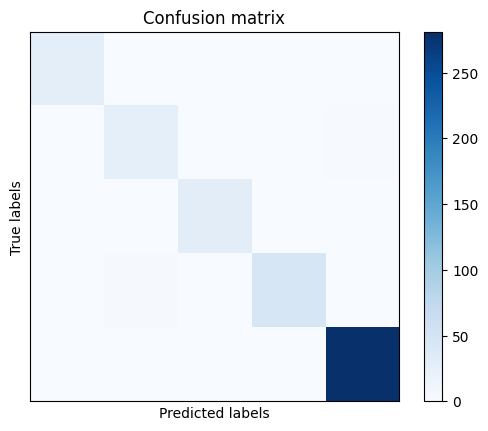

0 is label drake
1 is label maroon 5
2 is label eminem
3 is label beyoncé
4 is label unknown


In [48]:
calculate_confusion_matrix_and_report(predicted, y_test)
for idx, l in enumerate(labels):
    print("{} is label {}".format(idx, l))